In [1]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# from notebooks.utils import plot_images, plot_matches, add_frame
from hfnet.models import get_model  
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

In [2]:
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    print(len(image_path))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path

In [3]:
path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/ipadT3images')

1850


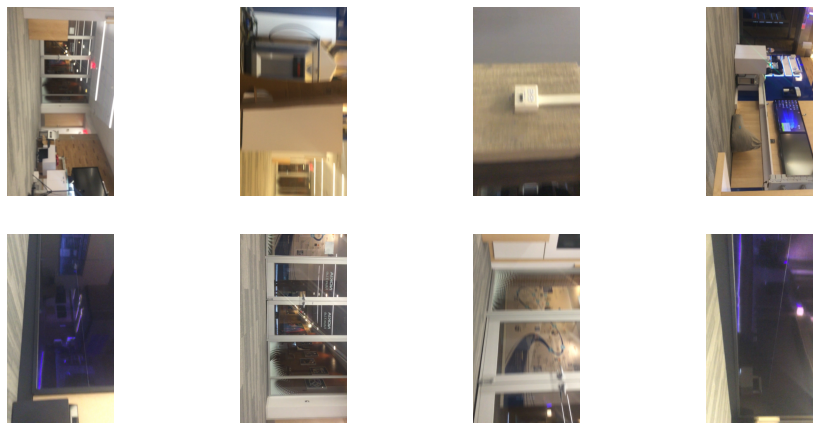

In [4]:
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4) 

In [19]:
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict

In [6]:
image_dict = dictionary_of_images(image_path)
print(len(image_dict))

1850it [00:21, 85.85it/s] 

1850


In [5]:
output_path = Path("/home/Hierarchical-Localization/outputs/ipadT3HFnet")
# output_path.mkdir()

In [27]:
#jss
import argparse
import logging
from pathlib import Path
import h5py
import numpy as np
import torch
import json
import cv2
import numpy as np
from pathlib import Path
from hfnet.settings import EXPER_PATH
# from notebooks.utils import plot_images, plot_matches, add_frame

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
tf.contrib.resampler  # import C++ op

%load_ext autoreload
%autoreload 2
%matplotlib inline

W0224 05:57:17.505560 140519328192320 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
class HFNet:
    def __init__(self, model_path, outputs):
        self.session = tf.Session()
        self.image_ph = tf.placeholder(tf.float32, shape=(None, None, 3))

        net_input = tf.image.rgb_to_grayscale(self.image_ph[None])
        tf.saved_model.loader.load(
            self.session, [tag_constants.SERVING], str(model_path),
            clear_devices=True,
            input_map={'image:0': net_input})

        graph = tf.get_default_graph()
        self.outputs = {n: graph.get_tensor_by_name(n+':0')[0] for n in outputs}
        self.nms_radius_op = graph.get_tensor_by_name('pred/simple_nms/radius:0')
        self.num_keypoints_op = graph.get_tensor_by_name('pred/top_k_keypoints/k:0')

    def inference(self, image, nms_radius=4, num_keypoints=1000):
        inputs = {
            self.image_ph: image[..., ::-1].astype(np.float),
            self.nms_radius_op: nms_radius,
            self.num_keypoints_op: num_keypoints,
        }
        return self.session.run(self.outputs, feed_dict=inputs)

In [26]:
model_path = Path("/home/Hierarchical-Localization/hfnet/model/saved_models/hfnet")

outputs = ['global_descriptor', 'keypoints', 'local_descriptors', 'scores']
hfnet = HFNet(model_path, outputs)

NameError: name 'tf' is not defined

In [11]:
global_feature_path = output_path/"global_features.h5"
local_feature_path = output_path/"local_feature.h5"
global_feature_file = h5py.File(str(global_feature_path), 'w')
local_feature_file = h5py.File(str(local_feature_path), 'w')
global_feature_dict = {}
for i in tqdm(range(len(image_dict))):
    image = (image_dict[i]["image"]).astype(float)
#     print(image.shape)
    name = image_dict[i]["name"]
    db = hfnet.inference(image)
    grp = global_feature_file.create_group(str(name))
    grp.create_dataset('global_descriptor', data=db['global_descriptor'])
    if i == 0:
        global_matrix = np.array(db['global_descriptor'])
    else:
        global_matrix = np.vstack((global_matrix,db['global_descriptor'])) 
    global_feature_dict[i] = {"global_descriptor":db['global_descriptor'], "name":name}
    grp = local_feature_file.create_group(str(name))
    size = np.array(image.shape[:2][::-1])
#     print(size)
    grp.create_dataset('keypoints', data=db['keypoints'])
    grp.create_dataset('descriptors', data=np.transpose(db['local_descriptors']))
    grp.create_dataset('scores', data=db['scores'])
    grp.create_dataset('image_size', data= size)
    
global_feature_file.close()
local_feature_file.close()

100%|██████████| 1850/1850 [01:01<00:00, 30.27it/s]


In [12]:
np.shape(global_matrix)

(1850, 4096)

In [13]:
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)
## needs both global matrix and dict as we need to give names too
## I am idiot if I keep wiritng codes like this one lol ;)
# Need to change it hehehe
# Writing the .txt file.
def text_file_for_global_matches(global_feature_dict, global_feature_matrix, path, number): 
    predictions_dict_matches = {}
    for i in tqdm(range(len(global_feature_dict))):
        current_descriptor = global_feature_matrix[i, :]
        neighbours = compute_distance(current_descriptor, global_feature_matrix)
        predictions_dict_matches[i] = ((np.argsort(neighbours))[:number])[1 :]
    #first writing the file
    output_file_txt = path/"global_feature.txt"
    with open(output_file_txt, 'w') as f:
        for i in tqdm(range(len(predictions_dict_matches))):
            current_image_name = global_feature_dict[i]["name"]
            current_image_matches = predictions_dict_matches[i]
            string_list = []
            for j in range(len(current_image_matches)):
                    if i == 0 and j ==0:
                        making_a_string = current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    
                    else: 
                        making_a_string = "\n" + current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    f.write(making_a_string)  
    ## checking common lines and rewriting
    image_list_for_finding_common_separated = []
    with open(output_file_txt, 'r') as f:
        image_list_for_finding_common = [l.strip() for l in f]
    for i in range(len(image_list_for_finding_common)):
        current_index_value = image_list_for_finding_common[i]
        current_index_value = list(current_index_value.split(" "))
        image_list_for_finding_common_separated.append(sorted(current_index_value))
    ilf = sorted(image_list_for_finding_common_separated)
    final_list = []
    for i in range(len(ilf)):
        if ilf[i] in final_list:
            pass
        else:
            final_list.append(ilf[i])
    with open(output_file_txt, 'w') as f:
        for i in range(len(final_list)):
            if i == 0:
                making_a_string = final_list[i][0]+ " " + final_list[i][1]
            else:
                making_a_string = "\n" + final_list[i][0]+ " " + final_list[i][1]
            f.write(making_a_string)

In [14]:
text_file_for_global_matches(global_feature_dict, global_matrix,output_path,50)

100%|██████████| 1850/1850 [00:00<00:00, 14585.81it/s]


In [6]:
### Bringing in HLOC
%load_ext autoreload
%autoreload 2
from hloc import extract_features, match_features, reconstruction, visualization
feature_conf_superpoint = {'output': 'local_feature', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}
# os.environ["CUDA_VISIBLE_DEVICES"] = '5'


In [7]:
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features = feature_conf_superpoint['output']
sfm_pairs = output_path/"global_feature.txt"

In [ ]:
match_features.main(matcher_conf, sfm_pairs, features, output_path)

[02/24/2021 02:55:58 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


 98%|█████████▊| 55539/56572 [45:21<00:50, 20.40it/s]

In [ ]:
sfm_dir = output_path/'sfm_superpoint+superglue'
feature_file = output_path/'local_feature.h5'
match_file = output_path/'local_feature_matches-superglue_global_feature.h5'

In [ ]:
import argparse
import logging
from pathlib import Path
import shutil
import multiprocessing
import subprocess
import pprint

from hloc.utils.read_write_model import read_cameras_binary
from hloc.utils.database import COLMAPDatabase
from hloc.triangulation import (
    import_features, import_matches, geometric_verification)


def create_empty_db(database_path):
    logging.info('Creating an empty database...')
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    db.commit()
    db.close()


def import_images(colmap_path, sfm_dir, image_dir, database_path,
                  single_camera=False):
    logging.info('Importing images into the database...')
    images = list(image_dir.iterdir())
    if len(images) == 0:
        raise IOError(f'No images found in {image_dir}.')

    # We need to create dummy features for COLMAP to import images with EXIF
    dummy_dir = sfm_dir / 'dummy_features'
    dummy_dir.mkdir()
    for i in images:
        with open(str(dummy_dir / (i.name + '.txt')), 'w') as f:
            f.write('0 128')

    cmd = [
        str(colmap_path), 'feature_importer',
        '--database_path', str(database_path),
        '--image_path', str(image_dir),
        '--import_path', str(dummy_dir),
        '--ImageReader.single_camera',
        str(int(single_camera))]
    ret = subprocess.call(cmd)
    if ret != 0:
        logging.warning('Problem with feature_importer, exiting.')
        exit(ret)

    db = COLMAPDatabase.connect(database_path)
    db.execute("DELETE FROM keypoints;")
    db.execute("DELETE FROM descriptors;")
    db.commit()
    db.close()
    shutil.rmtree(str(dummy_dir))


def get_image_ids(database_path):
    db = COLMAPDatabase.connect(database_path)
    images = {}
    for name, image_id in db.execute("SELECT name, image_id FROM images;"):
        images[name] = image_id
    db.close()
    return images


# def run_reconstruction(colmap_path, model_path, database_path, image_dir,
#                        min_num_matches=None):
#     logging.info('Running the 3D reconstruction...')
#     model_path.mkdir(exist_ok=True)

#     cmd = [
#         str(colmap_path), 'mapper',
#         '--database_path', str(database_path),
#         '--image_path', str(image_dir),
#         '--output_path', str(model_path)]
# #     ,
# #         '--Mapper.num_threads', str(min(multiprocessing.cpu_count(), 16))]
#     if min_num_matches:
#         cmd += ['--Mapper.min_num_matches', str(min_num_matches)]
#     logging.info(' '.join(cmd))
#     ret = subprocess.call(cmd)
#     if ret != 0:
#         logging.warning('Problem with mapper, exiting.')
#         exit(ret)

#     models = list(model_path.iterdir())
#     if len(models) == 0:
#         logging.error('Could not reconstruct any model!')
#         return False
#     logging.info(f'Reconstructed {len(models)} models.')

#     largest_model = None
#     largest_model_num_images = 0
#     for model in models:
#         num_images = len(read_cameras_binary(str(model / 'cameras.bin')))
#         if num_images > largest_model_num_images:
#             largest_model = model
#             largest_model_num_images = num_images
#     assert largest_model_num_images > 0
#     logging.info(f'Largest model is #{largest_model.name} '
#                  'with {largest_model_num_images} images.')

#     stats_raw = subprocess.check_output(
#         [str(colmap_path), 'model_analyzer',
#          '--path', str(largest_model)])
#     stats_raw = stats_raw.decode().split("\n")
#     stats = dict()
#     for stat in stats_raw:
#         if stat.startswith("Registered images"):
#             stats['num_reg_images'] = int(stat.split()[-1])
#         elif stat.startswith("Points"):
#             stats['num_sparse_points'] = int(stat.split()[-1])
#         elif stat.startswith("Observations"):
#             stats['num_observations'] = int(stat.split()[-1])
#         elif stat.startswith("Mean track length"):
#             stats['mean_track_length'] = float(stat.split()[-1])
#         elif stat.startswith("Mean observations per image"):
#             stats['num_observations_per_image'] = float(stat.split()[-1])
#         elif stat.startswith("Mean reprojection error"):
#             stats['mean_reproj_error'] = float(stat.split()[-1][:-2])

#     return stats


def main(sfm_dir, image_dir, pairs, features, matches,
         colmap_path='colmap', single_camera=False,
         skip_geometric_verification=False,
         min_match_score=None, min_num_matches=None):

    assert features.exists(), features
    assert pairs.exists(), pairs
    assert matches.exists(), matches

    sfm_dir.mkdir(parents=True, exist_ok=True)
    database = sfm_dir / 'database.db'
    models = sfm_dir / 'models'
    models.mkdir(exist_ok=True)

    create_empty_db(database)
    import_images(
        colmap_path, sfm_dir, image_dir, database, single_camera)
    image_ids = get_image_ids(database)
    import_features(image_ids, database, features)
    import_matches(image_ids, database, pairs, matches,
                   min_match_score, skip_geometric_verification)
    if not skip_geometric_verification:
        geometric_verification(colmap_path, database, pairs)
#     stats = run_reconstruction(
#         colmap_path, models, database, image_dir, min_num_matches)
#     stats['num_input_images'] = len(image_ids)
#     logging.info(f'Statistics:\n{pprint.pformat(stats)}')

In [ ]:
main(
    sfm_dir,
    path_to_images_for_map,
    sfm_pairs,
    feature_file,
    match_file)

In [21]:
import subprocess
cmd = ["colmap", "mapper",
      '--project_path', str(sfm_dir/'models'/'project.ini')]

In [22]:
subprocess.call(cmd)

0

In [15]:
print("hi")

hi


In [20]:
"""reconstruction.main(
    sfm_dir,
    path_to_images_for_map,
    sfm_pairs,
    feature_file,
    match_file)"""

'reconstruction.main(\n    sfm_dir,\n    path_to_images_for_map,\n    sfm_pairs,\n    feature_file,\n    match_file)'

In [21]:
path_to_query = Path("/home/Hierarchical-Localization/datasets/testing")

In [22]:
image_path_query = image_directory_parser(path_to_query, viewer =False)

4


In [23]:
image_dict_query = dictionary_of_images(image_path_query)

4it [00:00, 66.49it/s]


In [24]:
global_feature_path = output_path/"global_features_query.h5"
local_feature_path = output_path/"local_feature_query.h5"
global_feature_file = h5py.File(str(global_feature_path), 'w')
local_feature_file = h5py.File(str(local_feature_path), 'w')
global_feature_dict_query = {}
for i in tqdm(range(len(image_dict_query))):
    image = (image_dict_query[i]["image"]).astype(float)
#     print(image.shape)
    name = image_dict_query[i]["name"]
    db = hfnet.inference(image)
    grp = global_feature_file.create_group(str(name))
    grp.create_dataset('global_descriptor', data=db['global_descriptor'])
    if i == 0:
        global_matrix_query = np.array(db['global_descriptor'])
    else:
        global_matrix_query = np.vstack((global_matrix,db['global_descriptor'])) 
    global_feature_dict_query[i] = {"global_descriptor":db['global_descriptor'], "name":name}
    grp = local_feature_file.create_group(str(name))
    size = np.array(image.shape[:2][::-1])
#     print(size)
    grp.create_dataset('keypoints', data=db['keypoints'])
    grp.create_dataset('descriptors', data=np.transpose(db['local_descriptors']))
    grp.create_dataset('scores', data=db['scores'])
    grp.create_dataset('image_size', data= size)
    
global_feature_file.close()
local_feature_file.close()

  0%|          | 0/4 [00:00<?, ?it/s]


NameError: name 'hfnet' is not defined

In [47]:
def query_global_txt_file_creator(image_dict_query, image_dict_map, global_matrix, predictions_dict_query, path, file_name, number):
    with open(path/file_name, 'w') as f:
        for i in tqdm(range(len(predictions_dict_query))):
            current_descriptor = predictions_dict_query[i]["global_descriptor"]
            neighbours = compute_distance(current_descriptor, global_matrix)
            global_matches = ((np.argsort(neighbours))[:number])
            for j in range(len(global_matches)):
                if i == 0 and j ==0:
                    string = image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                else:
                    string = "\n"+ image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                f.write(string)

In [33]:
global_file_txt = "global_query.txt"
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)

In [34]:
query_global_txt_file_creator(image_dict_query, image_dict, global_matrix,global_feature_dict_query, output_path, global_file_txt, 10)

NameError: name 'query_global_txt_file_creator' is not defined

In [35]:
matcher_conf_query = {'output': 'matcher_query', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features_query = 'local_feature_query'
loc_pairs = output_path/global_file_txt

In [39]:
from hloc import feature_matcher_map_query

In [40]:
feature_matcher_map_query.main(matcher_conf_query, loc_pairs, features, output_path, features_query)

I0224 06:00:50.490801 140519328192320 feature_matcher_map_query.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matcher_query'}
I0224 06:00:50.492466 140519328192320 feature_matcher_map_query.py:50] Using query_features local_feature_query
  5%|▌         | 2/40 [00:00<00:02, 14.86it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 40/40 [00:02<00:00, 17.19it/s]
I0224 06:00:53.061681 140519328192320 feature_matcher_map_query.py:127] Finished exporting matches.


In [23]:
filename = "queries_with_intrinsics.txt"
with open(output_path/filename, 'w') as f:
    for i in range(len(image_path_query)):
        name = image_path_query[i].name
        if i ==0:
            string = str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        else:
            string = "\n"+  str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        f.write(string)    

In [41]:
sfm = sfm_dir/'models'/'0'
feat_name = "local_feature_query.h5"
mat_name = "local_feature_matcher_query_global_query.h5"
res_name = 'results.txt'

In [42]:
from hloc import localize_sfm
localize_sfm.main(sfm,
                 output_path/"queries_with_intrinsics.txt",
                 loc_pairs,
                 output_path/feat_name,
                 output_path/mat_name,
                 output_path/res_name,
                 covisibility_clustering=False)

I0224 06:01:06.236222 140519328192320 parsers.py:16] Importing 4 queries in queries_with_intrinsics.txt
I0224 06:01:06.238216 140519328192320 localize_sfm.py:110] Reading 3D model...
I0224 06:01:08.053731 140519328192320 localize_sfm.py:124] Starting localization...
 25%|██▌       | 1/4 [00:00<00:00,  7.79it/s]

float64
float64


100%|██████████| 4/4 [00:00<00:00,  8.24it/s]
I0224 06:01:08.543642 140519328192320 localize_sfm.py:188] Localized 4 / 4 images.
I0224 06:01:08.544631 140519328192320 localize_sfm.py:189] Writing poses to /home/Hierarchical-Localization/outputs/ipadT3HFnet/results.txt...
I0224 06:01:08.546919 140519328192320 localize_sfm.py:199] Writing logs to /home/Hierarchical-Localization/outputs/ipadT3HFnet/results.txt_logs.pkl...
I0224 06:01:08.551275 140519328192320 localize_sfm.py:202] Done!


float64
float64


In [43]:
from hloc import  visualization

In [44]:
local_feature_path = output_path/"local_feature.h5"
local_feature_path_query = output_path/"local_feature_query.h5"

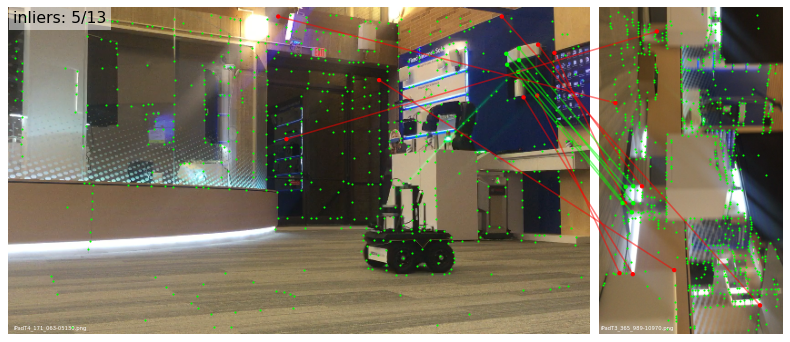

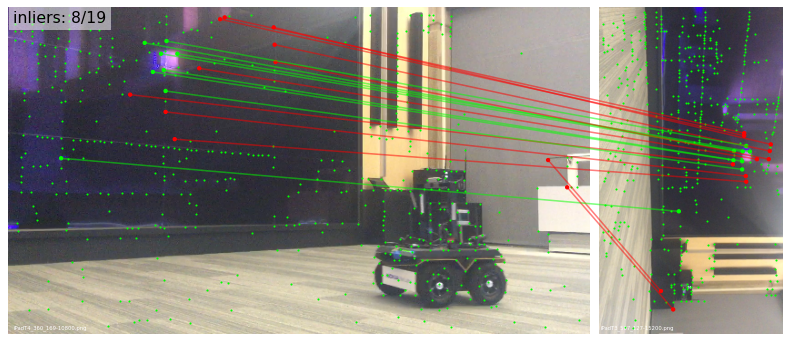

In [ ]:
visualization.visualize_loc_new(
    output_path/res_name, path_to_images_for_map,path_to_query,local_feature_path, local_feature_path_query,  sfm, n=4, top_k_db=1, seed=2)

In [31]:
f = h5py.File(str(local_feature_path),'r')

In [36]:
f['iPadT3_0_300-00010.png']['keypoints'].__array__()

array([[248, 233],
       [239,  59],
       [295, 454],
       [110, 451],
       [288, 631],
       [308, 628],
       [ 99, 345],
       [347, 473],
       [347, 388],
       [337, 292],
       [342, 536],
       [309,   9],
       [195, 397],
       [151, 606],
       [158, 585],
       [230, 161],
       [ 91, 415],
       [348, 426],
       [214,   9],
       [347, 407],
       [189, 452],
       [319, 482],
       [106,  70],
       [147, 568],
       [255,  46],
       [289, 234],
       [315, 313],
       [ 47, 138],
       [ 75, 239],
       [218, 378],
       [245, 174],
       [233, 391],
       [197, 414],
       [ 87, 438],
       [180, 362],
       [336, 160],
       [284, 412],
       [234, 438],
       [348, 345],
       [327, 124],
       [103, 434],
       [306, 608],
       [273, 237],
       [177, 576],
       [ 54, 336],
       [240, 354],
       [188,  65],
       [283, 425],
       [166, 340],
       [318, 301],
       [264, 231],
       [  9, 251],
       [189,